# Postprocessing pipeline with SpikeInterface

In [1]:
# Parameters

session_name = "Wifi_20240430"

bin_data_path = r"C:\Users\boninilab\Desktop\kilosort-test\sorting-test-Wifi_20240430\binary_files\Wifi_20240430_good_heatmap.bin"
sorted_data_path = r"C:\Users\boninilab\Desktop\kilosort-test\sorting-test-Wifi_20240430\kilosort4_output_tests\Wifi_20240430_test6"
probe_file_path = "wifi_channel_map_kilosort.prb"
sampling_frequency = 32000.0  
num_channels = 128  
dtype = "uint16"
voltage_res = 0.2 # see deuteron info
acd_bits = 16 # see deuteron info

# Time window for the waveforms / templates
ms_before = 1.0
ms_after = 2.0

# Time points for the waveforms / templatess
wf_npoints = 1000

# Path for results
results_dir = r"C:\Users\boninilab\Desktop\kilosort-test\sorting-test-Wifi_20240430\sorting-results-k4\Wifi_20240430_test7_results"




In [2]:
# ===========================================================================
# Testing the postprocessing pipeline analyses for the sorted Wifi_20240430 session with kilosort4
# ===========================================================================
import spikeinterface as si


import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

# Loading the bin data 
file_path = Path(bin_data_path)

# Confirm file existence
assert file_path.is_file(), f"Error: {file_path} is not a valid file. Please check the path."

# Define recording parameters
gain_to_uV = voltage_res
offset_to_uV = - 2 ** (acd_bits - 1) * gain_to_uV

# Load data using SpikeInterface
recording = si.read_binary(
    file_paths=file_path,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype=dtype,
    gain_to_uV=gain_to_uV,
    offset_to_uV=offset_to_uV
)

# Load the probe configuration
from probeinterface import read_prb

probe_file = Path(probe_file_path)
probe = read_prb(probe_file)

recording.set_probegroup(probe, in_place=True)

recording

BinaryRecordingExtractor: 128 channels - 32.0kHz - 1 segments - 128,791,427 samples 
                          4,024.73s (1.12 hours) - uint16 dtype - 30.71 GiB
  file_paths: ['C:\\Users\\boninilab\\Desktop\\kilosort-test\\sorting-test-Wifi_20240430\\binary_files\\Wifi_20240430_good_heatmap.bin']

In [4]:
# Load the sorting result from kilosort4/phy
from spikeinterface.extractors import read_phy

sorting_path = Path(sorted_data_path)
sorting = read_phy(sorting_path)#, exclude_cluster_groups=['noise', 'mua', 'unsorted'])
sorting.set_property("group", sorting.get_property("channel_group"))
sorting

PhySortingExtractor: 153 units - 1 segments - 32.0kHz

In [5]:
# Create the SortingAnalyzer
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording,
    sparse=True, # Use a sparse representation, so keeps only info of relevant channel(s)
    # Args for estimate_sparsity function
    num_spikes_for_sparsity=1000,
    peak_sign="neg",
    ms_before=ms_before,
    ms_after=ms_after,
    method="best_channels",
    num_channels=1, # Select the single best channel, i.e. the one the sorting associates to the unit/cluster in kilosort
    amplitude_mode="peak_to_peak", # select based on the difference betwenne min amplitude and max amplitude
    format="memory", # Keep on memory, saved to sika just the final results
)

print(analyzer)

estimate_sparsity (no parallelization):   0%|          | 0/4025 [00:00<?, ?it/s]

SortingAnalyzer: 128 channels - 153 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions


In [6]:
# Compute the sorting metrics
job_kwargs = dict(n_jobs=8, chunk_duration="2s", progress_bar=True)
compute_dict = {
    'random_spikes': {'method': 'uniform', 'max_spikes_per_unit': 5000},
    'waveforms': {'ms_before': ms_before, 'ms_after': ms_after, "dtype": "float32"},
    'templates': {'operators': ["average"]},
    'template_similarity': {'method': 'cosine_similarity'},
    'correlograms': {'window_ms': 20.0, 'bin_ms': 0.5, 'method': 'numba'},
    'isi_histograms': {'window_ms': 100.0, 'bin_ms': 0.5, 'method': 'numba'},
    'template_metrics': {'upsampling_factor': 1000, 'sparsity': analyzer.sparsity},
    'spike_amplitudes': {'peak_sign': 'neg'},
    'unit_locations': {'method': 'monopolar_triangulation'},
}
analyzer.compute(compute_dict, **job_kwargs)

analyzer

compute_waveforms (workers: 8 processes):   0%|          | 0/2013 [00:00<?, ?it/s]

c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Compute : spike_amplitudes (workers: 8 processes):   0%|          | 0/2013 [00:00<?, ?it/s]

SortingAnalyzer: 128 channels - 153 units - 1 segments - memory - sparse - has recording
Loaded 9 extensions: random_spikes, waveforms, templates, template_similarity, correlograms, isi_histograms, template_metrics, unit_locations, spike_amplitudes

In [7]:
ext_templates = analyzer.get_extension("templates")

av_templates = ext_templates.get_data(operator="average")
print("Templates shape: ", av_templates.shape)

Templates shape:  (153, 96, 128)


In [8]:
# Extract the waveform templates ans spk trains

from scipy.interpolate import interp1d

neurons = []
total_neurons_number = len(sorting.get_unit_ids())
cluster_ids = sorting.get_unit_ids()

# Retrieve the templates
av_templates = analyzer.get_extension("templates").get_data(operator="average")

marked_channels = []
marked_letters = []

# Loop over all the clusters and extract the waveforms and spk trains
for unit_id in cluster_ids:

    channel_id = analyzer.sparsity.unit_id_to_channel_ids[unit_id][0]
    unit_index = np.where(np.array(cluster_ids) == unit_id)[0][0]
    template = av_templates[unit_index]


    # Interpolate the template to get 1000 points
    npoints = 1000
    original_times = np.linspace(0., 3., 96)  # Original 96 points
    target_times = np.linspace(0., 3., npoints)  # Target 1000 points

    # Create interpolation function (cubic gives smoother results)
    f = interp1d(original_times, template[:,channel_id], kind='cubic')
    # Apply interpolation to get upsampled template
    unit_template = f(target_times)
    
    # Retrieve the spk train for this unit
    unit_spk_times = sorting.get_unit_spike_train(unit_id=unit_id, return_times=True)
    
    # Use the standard format to label units: Spk_xxxY_[wf,sh] 
    
    # Add channles and starting letter if channel encoutered for the first time
    if channel_id not in marked_channels:
        marked_channels.append(channel_id)
        marked_letters.append(97) # 97 is the ASCII code for 'a'
        letter_index = 97
    else:
        # If channel already encoutered, update the relative letter and retrieve it
        channel_idx = marked_channels.index(channel_id)
        marked_letters[channel_idx] += 1
        letter_index = marked_letters[channel_idx]
        
        
    # Format channel as 3-digit number
    channel_str = f"{channel_id:03d}"
    letter = chr(letter_index)  # Convert to character
    
    wf_id_str = f"Spk_{channel_str}{letter}_wf"
    spk_times_id_str = f"Spk_{channel_str}{letter}_sh"
    
    
    # Create a dictornary to store the relative information
    d = {
        "session": session_name,
        "id": wf_id_str,
        "wf": unit_template,
        "spk_times": unit_spk_times
    }
    
    neurons.append(d)

In [9]:
# Compute ISI for each neuron

# Set the bins width based on a sensitivity
isi_sens_ms = 0.5 # sensitivity in ms for each bin

# Choose a limit for isi visualization and some computing
isi_max_visual_ms = 100 # ms 

for i in range(total_neurons_number):
    neurons[i]["isi_ms"] = np.diff(neurons[i]["spk_times"]) * 1e3

    # Compute ISI distr
    # isi_bins_ms = np.linspace(0.,
    #                           neurons[i]["isi_ms"].max(),
    #                           int(neurons[i]["isi_ms"].max() / isi_sens_ms),
    #                           dtype = np.float32)
    isi_bins_ms = np.arange(0, neurons[i]["isi_ms"].max() + isi_sens_ms, isi_sens_ms, dtype=np.float32)
    isi_max_visual_idx = np.argwhere(isi_bins_ms <= isi_max_visual_ms)[-1]
    
    isi_freq_ms, _ = np.histogram(neurons[i]["isi_ms"], bins=isi_bins_ms)
    
    neurons[i]["isi_dist_bins_ms"] = isi_bins_ms
    neurons[i]["isi_dist_freq"] = isi_freq_ms
    neurons[i]["isi_max_visual_idx"] = isi_max_visual_idx


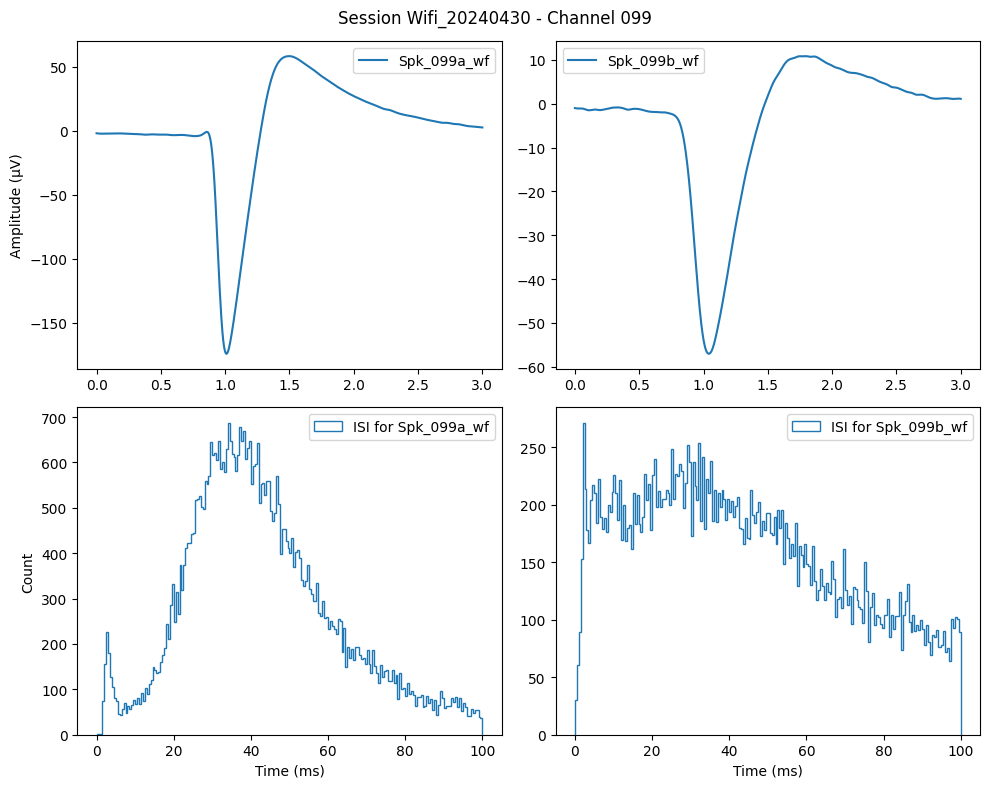

(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: ylabel='Amplitude (µV)'>, <Axes: >],
        [<Axes: xlabel='Time (ms)', ylabel='Count'>,
         <Axes: xlabel='Time (ms)'>]], dtype=object))

In [10]:
# Plot neuron waveform with ISI histograms

wf_time_ms = np.linspace(0., 3., npoints)

def plot_wf_isi(session, channel, fig_close = False):
    channel = f"{channel:03d}"
    neurons_id_list = [neurons[i]["id"] for i in range(total_neurons_number) if channel in neurons[i]["id"] and neurons[i]["session"] == session]

    if len(neurons_id_list) == 0:
        print(f"No neurons found for session {session} and channel {channel}")
        return None, None

    # Create a 2-row figure: waveforms on top, ISI histograms on bottom
    fig, axs = plt.subplots(2, len(neurons_id_list), figsize=(int(len(neurons_id_list)*5), 8), sharey=False)

    if len(neurons_id_list) > 1:
        for i, neuron_id in enumerate(neurons_id_list):
            # Get neuron index for this ID
            neuron_idx = next(j for j in range(total_neurons_number) if neurons[j]["id"] == neuron_id and neurons[j]["session"] == session)
            
            # Plot waveform in top row
            axs[0, i].plot(wf_time_ms, neurons[neuron_idx]["wf"], label=neuron_id)
            axs[0, 0].set_ylabel("Amplitude (µV)")
            axs[0, i].legend()
            
            # Plot ISI histogram in bottom row
            axs[1, i].hist(neurons[neuron_idx]["isi_ms"],
                        bins=neurons[neuron_idx]["isi_dist_bins_ms"][:neurons[neuron_idx]["isi_max_visual_idx"][0]+1],
                        histtype="step",
                        label=f"ISI for {neurons_id_list[i]}")
            axs[1, i].legend()
            axs[1, i].set_xlabel("Time (ms)")
            axs[1, 0].set_ylabel("Count")
    else:
        # Get neuron index for the single ID
        neuron_idx = next(j for j in range(total_neurons_number) if neurons[j]["id"] == neurons_id_list[0] and neurons[j]["session"] == session)
        
        # Plot waveform in top row
        axs[0].plot(wf_time_ms, neurons[neuron_idx]["wf"], label=neurons_id_list[0])
        axs[0].set_title(f"Neuron {neurons_id_list[0]}")
        axs[0].set_ylabel("Amplitude (µV)")
        axs[0].legend()
        
        # Plot ISI histogram in bottom row
        axs[1].hist(neurons[neuron_idx]["isi_ms"],
                        bins=neurons[neuron_idx]["isi_dist_bins_ms"][:neurons[neuron_idx]["isi_max_visual_idx"][0]+1],
                        histtype="step",
                        label=f"ISI for {neurons_id_list[0]}")
        axs[1].legend()
        axs[1].set_xlabel("Time (ms)")
        axs[1].set_ylabel("Count")

    plt.suptitle(f"Session {session} - Channel {channel}")
    plt.tight_layout()
    if fig_close:
        plt.close(fig)
        return fig, axs
    else:
        plt.show()
        return fig, axs


session = "Wifi_20240430"
channel = 99

plot_wf_isi(session, channel)

In [11]:
session = "Wifi_20240430"
channel = "099"
len( [neurons[i]["spk_times"] for i in range(total_neurons_number) if channel in neurons[i]["id"] and neurons[i]["session"] == session][0] )

58288

In [19]:
import pathlib

wf_isi_by_channel_path = pathlib.Path(r"C:/Users/boninilab/Desktop/kilosort-test/sorting-test-Wifi_20240430/Plots") / "wf-isi-by-channel-kilosort"
wf_isi_by_channel_path.mkdir(parents=True, exist_ok=True)

# for i in range(128):
#     save_name = f"wf_isi_{session}_CH_{i:03d}"
#     save_path = wf_isi_by_channel_path / f"{save_name}.png"
    
#     fig, axs = plot_wf_isi(session, f"{i:03d}", fig_close=True)
#     if fig is not None:
#         fig.savefig(save_path, dpi=300)
    

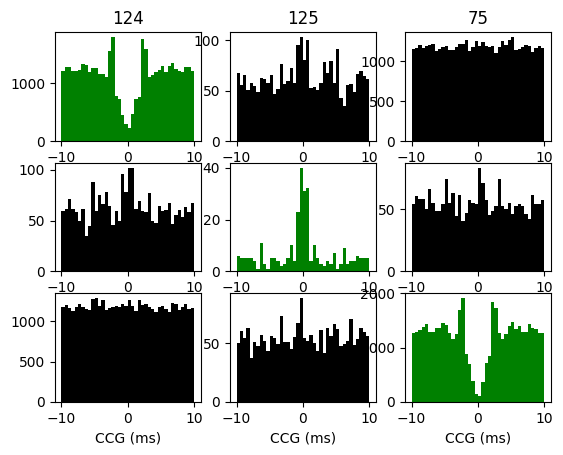

In [12]:
# Plot correlograms
from spikeinterface.widgets import plot_crosscorrelograms

plot_crosscorrelograms(
    analyzer,
    unit_ids=[124, 125, 75],
    backend="matplotlib"
)

In [24]:
cch = analyzer.get_extension("correlograms").get_data()

In [17]:
from spikeinterface.widgets import plot_sorting_summary

# this will open the GUI in a different window
plot_sorting_summary(sorting_analyzer=analyzer, unit_ids=cluster_ids, curation=True, backend='spikeinterface_gui')

ValueError: Length of values (153) does not match length of index (306)

In [12]:
# Save all the neurons id itendified in this sorting session
fpath = Path(r"C:\Users\boninilab\Desktop\kilosort-test\Results") 
fpath.mkdir(parents=True, exist_ok=True)
fpath = fpath / f"{session}-neurons-id-kilosort-test{sorted_data_path[-1]}.txt"
with open(fpath, "w") as f:
    for i in range(total_neurons_number):
        if neurons[i]["session"] == session:
            f.write(f"{neurons[i]['id']}\n")

In [ ]:
cluster_ids = sorting.get_unit_ids()
unit_id = 76
channel_id = analyzer.sparsity.unit_id_to_channel_ids[unit_id][0]

fig, ax = plt.subplots()
unit_index = np.where(np.array(cluster_ids) == unit_id)[0][0]
template = av_templates[unit_index]

from scipy.interpolate import interp1d

# Define original and target time points
npoints = 1000
original_times = np.linspace(0., 3., 96)  # Original 96 points
target_times = np.linspace(0., 3., npoints)  # Target 1000 points

# Create interpolation function (cubic gives smoother results)
f = interp1d(original_times, template[:,channel_id], kind='cubic')
# Apply interpolation to get upsampled template
template_upsampled = f(target_times)

wf_times = np.linspace(0., 3., npoints)

ax.plot(wf_times, template_upsampled, label=f"Channel {channel_id}")
ax.set_title(f"Cluster {unit_id}")
plt.legend()

plt.show()

tr_idx = np.argmin(template_upsampled)
pk_idx = tr_idx + np.argmax(template_upsampled[tr_idx:])
ttp = wf_times[pk_idx] - wf_times[tr_idx]
print("Time to peak: ", ttp)

In [39]:
# analyzer.compute(
#     input="template_metrics", upsampling_factor=npoints,
#     delete_existing_metrics=True,
#     sparsity=analyzer.sparsity
# )

# analyzer.get_extension("template_metrics").get_data()

In [35]:
# Saving resulta

# General directory
results_dir = Path(results_dir)
results_dir.mkdir(parents=True, exist_ok=True)

# Waveform dir
waveform_dir = results_dir / "Waveforms"
waveform_dir.mkdir(parents=True, exist_ok=True)

# Spk times dir
spk_times_dir = results_dir / "Spike Times"
spk_times_dir.mkdir(parents=True, exist_ok=True)

# List of clusters
cluster_ids = sorting.get_unit_ids()

In [ ]:
from scipy.interpolate import interp1d
import os
import scipy.io as sio

# Retrieve the templates / waveforms
av_templates = analyzer.get_extension("templates").get_data(operator="average")

# Initialize a dictionary to store templates by channel
# Structure: {channel_id: [template1, template2, ...]}
templates_by_channel = {i: [] for i in range(128)}
spk_times_by_channel = {i: [] for i in range(128)}

for unit_id in cluster_ids:
    
    # Get the single channel associated with the cluster
    channel_id = analyzer.sparsity.unit_id_to_channel_ids[unit_id][0]
    unit_index = np.where(np.array(cluster_ids) == unit_id)[0][0]
    unit_template = av_templates[unit_index][:, channel_id]
    
    # Get the spike times
    unit_spk_times = sorting.get_unit_spike_train(unit_id=unit_id, return_times=True)
    
    original_times = np.linspace(0., 3., unit_template.shape[0])  # Original samples of waveforms points
    target_times = np.linspace(0., 3., npoints)  # Target points

    # Create interpolation function (cubic gives smoother results)
    f = interp1d(original_times, unit_template, kind='cubic')
    # Apply interpolation to get upsampled template
    unit_template = f(target_times)
    
    # Store in our dictionary
    templates_by_channel[channel_id].append(unit_template)
    spk_times_by_channel[channel_id].append(unit_spk_times)
    

# Second pass: save templates to .mat files in groups of 32 channels
for group_idx in range(4):  # 4 groups of 32 channels
    start_channel = group_idx * 32
    end_channel = start_channel + 32
    
    # Dictionary to store MATLAB variables for this group
    matlab_data_wf = {}
    matlab_data_sh = {}
    
    # Process each channel in this group
    for channel_id in range(start_channel, end_channel):
        # Format channel as 3-digit number
        channel_str = f"{channel_id:03d}"
        
        # Add each template and spike times for this channel with letter suffix
        for idx, template in enumerate(templates_by_channel[channel_id]):
            # Get letter suffix ('a', 'b', 'c', etc.)
            letter = chr(97 + idx)  # 97 is ASCII for 'a'
            
            # Create variable names
            var_name = f"Spk_{channel_str}{letter}_wf"
            spk_var_name = f"Spk_{channel_str}{letter}_sh"
            
            # Add to data dictionary
            matlab_data_wf[var_name] = template
            matlab_data_sh[spk_var_name] = spk_times_by_channel[channel_id][idx]
    
    # Save to .mat file
    mat_filename_wf = waveform_dir / f"{session_name}_{start_channel+1}-{end_channel}_SUA_WF_K4.mat"
    mat_filename_sh = spk_times_dir / f"{session_name}_{start_channel+1}-{end_channel}_SUA_SH_K4.mat"
    sio.savemat(mat_filename_wf, matlab_data_wf)
    sio.savemat(mat_filename_sh, matlab_data_sh)